In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from langdetect import detect 
import html

pd.reset_option('all')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/1210054291.py:8: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/1210054291.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


## Raw data

- score: number of upvotes minus number of downvotes
- link_id (for comments): id of the submission to which the comment responded

In [2]:
submissions_raw = pd.read_csv("raw/investing_submissions.csv")
comments_raw = pd.read_csv("raw/investing_comments.csv")

In [3]:
submissions_raw.head()

,id,created,author,score,selftext,num_comments,link
0,6c6hw,2008-03-15 07:21,u/yuckatan,2,NaN,1,https://www.reddit.com/r/investing/comments/6c...
1,6cmtr,2008-03-19 07:18,u/Escafane,1,NaN,0,https://www.reddit.com/r/investing/comments/6c...
2,6cmut,2008-03-19 07:28,u/Escafane,1,NaN,0,https://www.reddit.com/r/investing/comments/6c...
3,6cmxh,2008-03-19 07:49,u/Escafane,2,NaN,0,https://www.reddit.com/r/investing/comments/6c...
4,6cmyx,2008-03-19 08:02,u/Escafane,1,NaN,0,https://www.reddit.com/r/investing/comments/6c...


In [4]:
comments_raw.head()

,id,link_id,created,author,score,body,link
0,c03g9j0,t3_6c6hw,2008-03-15 07:22,u/[deleted],1,[deleted],https://www.reddit.com/r/investing/comments/6c...
1,c03hwrh,t3_6ctth,2008-03-20 15:30,u/[deleted],1,[deleted],https://www.reddit.com/r/investing/comments/6c...
2,c03hwvj,t3_6ctth,2008-03-20 15:41,u/evilhero,1,p.s. It goes without saying that I'm long Veri...,https://www.reddit.com/r/investing/comments/6c...
3,c03idyn,t3_6cxcc,2008-03-22 10:00,u/[deleted],1,[deleted],https://www.reddit.com/r/investing/comments/6c...
4,c04zsc3,t3_6vp5k,2008-08-10 10:31,u/[deleted],1,[deleted],https://www.reddit.com/r/investing/comments/6v...


## Data Cleaning

### Missing values

In [5]:
def remove_missing_data(raw_df, column):
    '''
    Filters all entries that have [removed] or [deleted] in their body/self 
    text column (as applicable). Also filters NaN values.
    
    Input: 
        - raw_df: Pandas dataframe
        - column: Target column to look for missing values
    
    Returns:
        - Cleaned dataframe
    '''

    print("DataFrame shape before cleaning:", raw_df.shape)

    #Remove rows with values of "[removed]" or "[deleted]" on body/self text
    to_filter = ["[removed]", "[deleted]", "\[deleted\]"]
    mask = ~raw_df[column].isin(to_filter)
    filtered_df = raw_df[mask]

    print("DataFrame shape after filtering removed values:", 
                                                 filtered_df.shape)
    
    #Filter NaN
    filtered_df = filtered_df.dropna(subset=[column])
    print("DataFrame shape after filtering NaN values:", filtered_df.shape)

    return filtered_df

In [6]:
submissions_filtered1 = remove_missing_data(submissions_raw, "selftext")
submissions_filtered1

DataFrame shape before cleaning: (355893, 7)
DataFrame shape after filtering removed values: (178534, 7)
DataFrame shape after filtering NaN values: (153656, 7)


,id,created,author,score,selftext,num_comments,link
532,8zc24,2009-07-08 11:08,u/dning,1,Free money for those that deposit enough funds!,0,https://www.reddit.com/r/investing/comments/8z...
663,96jqg,2009-08-01 01:09,u/[deleted],1,I'm looking into making some small share buys ...,3,https://www.reddit.com/r/investing/comments/96...
708,998zv,2009-08-10 10:39,u/IndustrialEngineer,8,I'm considering investing a small amount of mo...,11,https://www.reddit.com/r/investing/comments/99...
805,9ghpv,2009-09-02 03:08,u/moscowvirgin,0,What is the best month to buy and sell shares ...,1,https://www.reddit.com/r/investing/comments/9g...
855,9ivio,2009-09-09 11:50,u/ctreia,0,The economy couldn’t be better for some people...,0,https://www.reddit.com/r/investing/comments/9i...
...,...,...,...,...,...,...,...
355881,18vho8v,2023-12-31 15:32,u/herpaderp9999,1,"Recently, I took over an account and removed t...",2,https://www.reddit.com/r/investing/comments/18...
355882,18vhy52,2023-12-31 15:46,u/streetskaterln91,85,Any recommendations? I'm thinking about openin...,71,https://www.reddit.com/r/investing/comments/18...
355883,18vi2ji,2023-12-31 15:53,u/milkcircle,1,I unexpectedly realized that the first paychec...,6,https://www.reddit.com/r/investing/comments/18...
355888,18vim1y,2023-12-31 16:20,u/tactical_llama2,1,I moved to the states with my wife just over a...,2,https://www.reddit.com/r/investing/comments/18...


In [7]:
comments_filtered1 = remove_missing_data(comments_raw, "body")
comments_filtered1

DataFrame shape before cleaning: (5639491, 7)
DataFrame shape after filtering removed values: (5150369, 7)
DataFrame shape after filtering NaN values: (5150192, 7)


,id,link_id,created,author,score,body,link
2,c03hwvj,t3_6ctth,2008-03-20 15:41,u/evilhero,1,p.s. It goes without saying that I'm long Veri...,https://www.reddit.com/r/investing/comments/6c...
7,c04ztc9,t3_6vp5k,2008-08-10 12:12,u/qquicksilver,3,Vegas / Drugs / Hookers,https://www.reddit.com/r/investing/comments/6v...
9,c04ztq5,t3_6vp5k,2008-08-10 12:51,u/mycall,0,not necessarily in that order,https://www.reddit.com/r/investing/comments/6v...
10,c04ztqb,t3_6vp5k,2008-08-10 12:52,u/radhruin,1,Get a Roth IRA and put that entire amount (plu...,https://www.reddit.com/r/investing/comments/6v...
12,c04zvs8,t3_6vp5k,2008-08-10 16:05,u/radhruin,1,At this point in your life you don't want shor...,https://www.reddit.com/r/investing/comments/6v...
...,...,...,...,...,...,...,...
5639486,kfro5dm,t3_18vf1xf,2023-12-31 17:54,u/Slayer41285,1,If I was 60 today I would get around $6000 a m...,https://www.reddit.com/r/investing/comments/18...
5639487,kfro7r1,t3_18vh2do,2023-12-31 17:55,u/bkweathe,7,"For a house down payment in a few years, yes!\...",https://www.reddit.com/r/investing/comments/18...
5639488,kfro9wy,t3_18vf1xf,2023-12-31 17:55,u/TheSarp101,1,"Oh wow, that is really nice!",https://www.reddit.com/r/investing/comments/18...
5639489,kfroeej,t3_18vfe0c,2023-12-31 17:56,u/Beautibulb_Tamer,1,Those are crazy returns. Care to share the tik...,https://www.reddit.com/r/investing/comments/18...


### Duplicates

In [8]:
submissions_filtered2 = submissions_filtered1.drop_duplicates(subset=['selftext'])
comments_filtered2 = comments_filtered1.drop_duplicates(subset=['body'])

print("Submissions df shape before filtering duplicates:", 
                             submissions_filtered1.shape)
    
print("Submissions df shape after filtering duplicates:", 
                             submissions_filtered2.shape)

print("Comments df shape before filtering duplicates:", 
                             comments_filtered1.shape)
    
print("Comments df shape after filtering duplicates:", 
                             comments_filtered2.shape)


Submissions df shape before filtering duplicates: (153656, 7)
Submissions df shape after filtering duplicates: (148889, 7)
Comments df shape before filtering duplicates: (5150192, 7)
Comments df shape after filtering duplicates: (4807797, 7)


### Clean text 

In [9]:
#https://www.w3schools.com/python/ref_string_translate.asp
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

def clean_text(s):
    '''
    Cleans text
    
        Inputs:
            - s (string)
            
        Returns:
            - cleaned string
    '''

    # Decode HTML entities (e.g., &amp;#x200B)
    text = html.unescape(s)

    # Decode again for any remaining HTML entities like &#x200B;
    text = html.unescape(text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove zero-width spaces explicitly
    text = text.replace('\u200B', '') 

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove words that have numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove apostrophes without adding space
    text = re.sub(r"'", '', text)  

    # Replace all other punctuation with space 
    text = re.sub(r"[^\w\s]", ' ', text) 
    
    # Remove line breaks
    text = text.replace('\n', ' ').replace('\r', ' ')

    # Collapse multiple spaces into a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase
    text = text.lower()

    # Remove unnecessary whitespace
    return text.strip()
    
submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/1548817189.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/1548817189.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))


### Delete very short texts

In [10]:
#Create column with word count to identify short texts
submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))
comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))

#Filter
print("Submissions shape before dropping short texts:", submissions_filtered2.shape)
submissions_filtered3 = submissions_filtered2[submissions_filtered2.word_count >= 50]
print("Submissions shape after dropping short texts:", submissions_filtered3.shape)

print("Comments shape before dropping short texts:", comments_filtered2.shape)
comments_filtered3 = comments_filtered2[comments_filtered2.word_count >= 50]
print("Comments shape after dropping short texts:", comments_filtered3.shape)

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/2268340447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/2268340447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))


Submissions shape before dropping short texts: (148889, 9)
Submissions shape after dropping short texts: (93222, 9)
Comments shape before dropping short texts: (4807797, 9)
Comments shape after dropping short texts: (1323007, 9)


### Sample down comments to reduce computation complexity from language detector. Keep around the same number of comments than on the self improvement corpus.

In [11]:
comments_sampled = comments_filtered3.sample(410000)

### Remove non-english posts

In [12]:
def checks_language(text):
    '''
    Checks if the language of the text is english or not
    
        Inputs:
            - s (string)
            
        Returns:
            - Boolean (True if text is in english)
    '''

    #If there's a problem with the text, simply return False
    try: 
        lang = detect(text)
    except:
        return False 
    
    if lang == "en":
        return True
    return False

submissions_filtered3['in_english'] = submissions_filtered3['cleaned_text'].apply(lambda x: checks_language(x))
comments_sampled['in_english'] = comments_sampled['cleaned_text'].apply(lambda x: checks_language(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/3827429750.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3['in_english'] = submissions_filtered3['cleaned_text'].apply(lambda x: checks_language(x))


Filter and only keep entries in english

In [13]:
submissions_filtered4 = submissions_filtered3[submissions_filtered3.in_english]
comments_filtered4 = comments_sampled[comments_sampled.in_english]

## Data engineering

### Combine submissions and comments

In [14]:
#Create column to identify them later
submissions_filtered4["type"] = "submission"
comments_filtered4["type"] = "comment"

#Concatenate
submissions_new = submissions_filtered4.rename(columns={'selftext': 'body'}, inplace=False)
complete_data = pd.concat([submissions_new, comments_filtered4], ignore_index=True)
complete_data


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/640623063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered4["type"] = "submission"
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/640623063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered4["type"] = "comment"


,id,created,author,score,body,num_comments,link,cleaned_text,word_count,in_english,type,link_id
0,96jqg,2009-08-01 01:09,u/[deleted],1,I'm looking into making some small share buys ...,3.0,https://www.reddit.com/r/investing/comments/96...,im looking into making some small share buys t...,86,True,submission,NaN
1,9ivio,2009-09-09 11:50,u/ctreia,0,The economy couldn’t be better for some people...,0.0,https://www.reddit.com/r/investing/comments/9i...,the economy couldnt be better for some people ...,99,True,submission,NaN
2,9snu1,2009-10-10 02:06,u/Facepuncher,3,"This was about maybe 6-7 years ago, I am think...",3.0,https://www.reddit.com/r/investing/comments/9s...,this was about maybe years ago i am thinking t...,51,True,submission,NaN
3,bs358,2010-04-16 20:42,u/theshadow47,2,"So I'm sober as a judge, about to go to sleep ...",2.0,https://www.reddit.com/r/investing/comments/bs...,so im sober as a judge about to go to sleep wh...,107,True,submission,NaN
4,c0q9t,2010-05-06 14:39,u/downpymt,7,I just sold my first house (a project house th...,9.0,https://www.reddit.com/r/investing/comments/c0...,i just sold my first house a project house tha...,84,True,submission,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
503153,hyzb27m,2022-03-01 17:51,u/8ean,1,There is so many speculation from the rich and...,NaN,https://www.reddit.com/r/investing/comments/t4...,there is so many speculation from the rich and...,116,True,comment,t3_t44j5g
503154,fm4a4ja,2020-04-01 09:06,u/optimal_substructure,1,"Most of the 'investors' I know, including at t...",NaN,https://www.reddit.com/r/investing/comments/fs...,most of the investors i know including at the ...,259,True,comment,t3_fs8lji
503155,h2zfu6h,2021-06-25 06:28,u/pragmojo,8,"It's not about the F150 itself, it's about oth...",NaN,https://www.reddit.com/r/investing/comments/o7...,its not about the itself its about other autom...,65,True,comment,t3_o7f1yr
503156,cn08e2v,2014-12-19 22:22,u/penisc0lada,1,"I'm just a college student, so I'm sure someon...",NaN,https://www.reddit.com/r/investing/comments/2p...,im just a college student so im sure someone c...,455,True,comment,t3_2psfva


### Create year and month columns

In [15]:
def extract_time(date_string):
    '''
    Extracts year and month of publication from the "created column
    
    Input:
        - date_string: date and hour of publication
        
    Returns:
        (tuple): year and date of publication'''
    date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")

    return date_object.year, date_object.month

complete_data[['year', 'month']] = complete_data['created'].apply\
                                           (lambda x: pd.Series(extract_time(x)))

## Exploratory Data Analysis

### Documents' length

Average number of words: 116.88213046398944


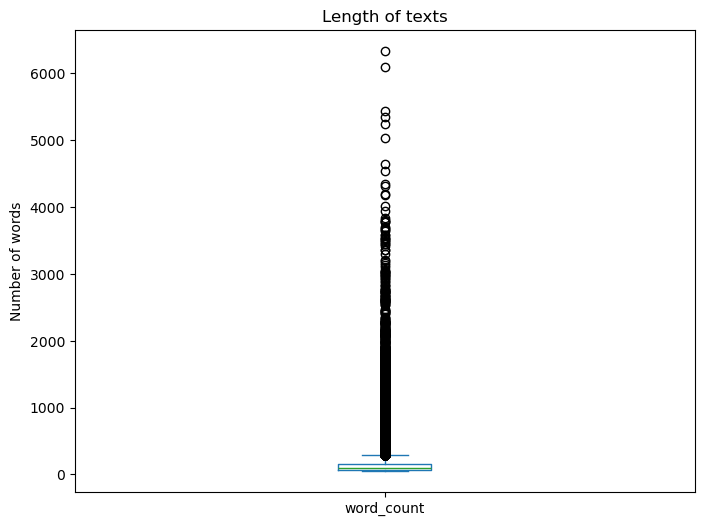

In [16]:
average_length = complete_data['word_count'].mean()
print(f"Average number of words: {average_length}")

# Create a boxplot of the word counts
plt.figure(figsize=(8, 6))
submissions_filtered3["word_count"].plot(kind='box')
plt.title('Length of texts')
plt.ylabel('Number of words')
plt.show()

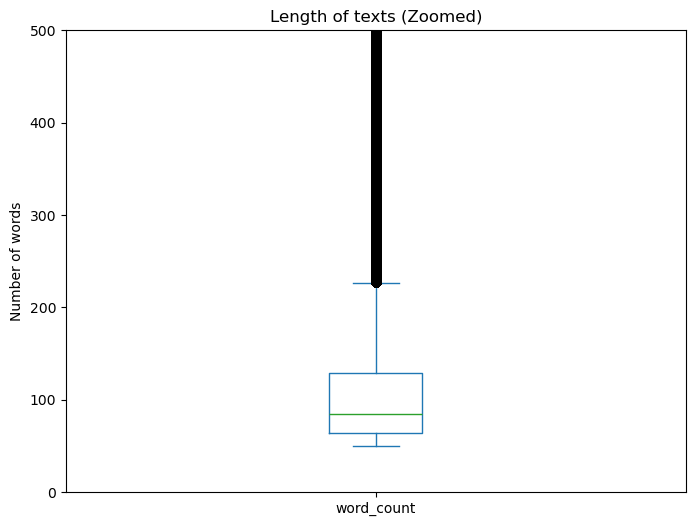

In [17]:
# Take a closer look
plt.figure(figsize=(8, 6))
complete_data["word_count"].plot(kind='box')
plt.title('Length of texts (Zoomed)')
plt.ylabel('Number of words')
plt.ylim(0, 500)  
plt.show()

### Year of publication distribution

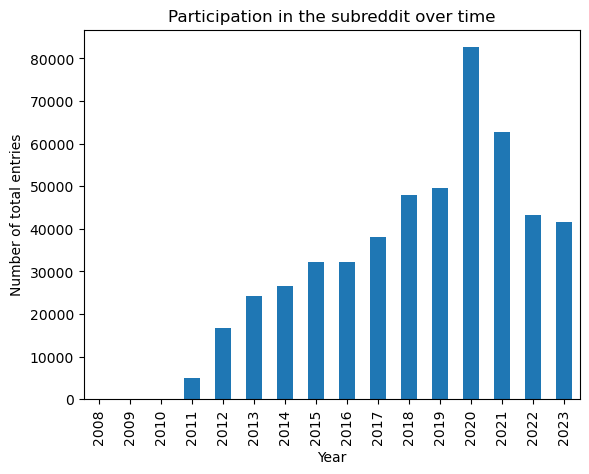

In [18]:
year_counts = complete_data['year'].value_counts().sort_index()

year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of total entries')
plt.title('Participation in the subreddit over time')
plt.show()

### Observe number of participants in the forum

In [19]:
authors = complete_data["author"]
print("{} unique authors".format(len(set(authors))))


136072 unique authors


## Export final df

In [20]:
#Exclude title and body columns from final data as they create some issues with the parsing of
#the CSV. Also delete in_english column since it won't be useful anymore
final_data = complete_data.drop(["body", "in_english"], axis=1, inplace=False)

In [21]:
final_data.to_csv('cleaned/investing_cleaned.csv')

Ensure correct parsing

In [22]:
saved_csv = pd.read_csv("cleaned/investing_cleaned.csv")

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7601/3723282458.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  saved_csv = pd.read_csv("cleaned/investing_cleaned.csv")


In [23]:
print(final_data.shape)
print(saved_csv.shape)

(503158, 12)
(503158, 13)
